Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 20000 files belonging to 10 classes.
Using 14000 files for training.
Class Names: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']
Number of classes: 10
Found 20000 files belonging to 10 classes.
Using 6000 files for validation.


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 7, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,142,090 (80.65 MB)

 Trainable params: 6,426,378 (24.51 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

Epoch 1/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 153s 343ms/step - accuracy: 0.6144 - loss: 1.4662 - val_accuracy: 0.9855 - val_loss: 0.0372
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 148s 339ms/step - accuracy: 0.9078 - loss: 0.2942 - val_accuracy: 0.9890 - val_loss: 0.0336
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 148s 339ms/step - accuracy: 0.9460 - loss: 0.1865 - val_accuracy: 0.9872 - val_loss: 0.0246
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 148s 339ms/step - accuracy: 0.9501 - loss: 0.1717 - val_accuracy: 0.9907 - val_loss: 0.0141
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 148s 339ms/step - accuracy: 0.9507 - loss: 0.1484 - val_accuracy: 0.9922 - val_loss: 0.0179
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 148s 338ms/step - accuracy: 0.9552 - loss: 0.1569 - val_accuracy: 0.9908 - val_loss: 0.0315
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 149s 339ms/step - accuracy: 0.9604 - loss: 0.1424 - val_accuracy: 0.9907 - val_loss: 0.0196
188/188 - 3s - 15ms/step - accuracy: 0.9907 - loss: 0.0141
Validation accura

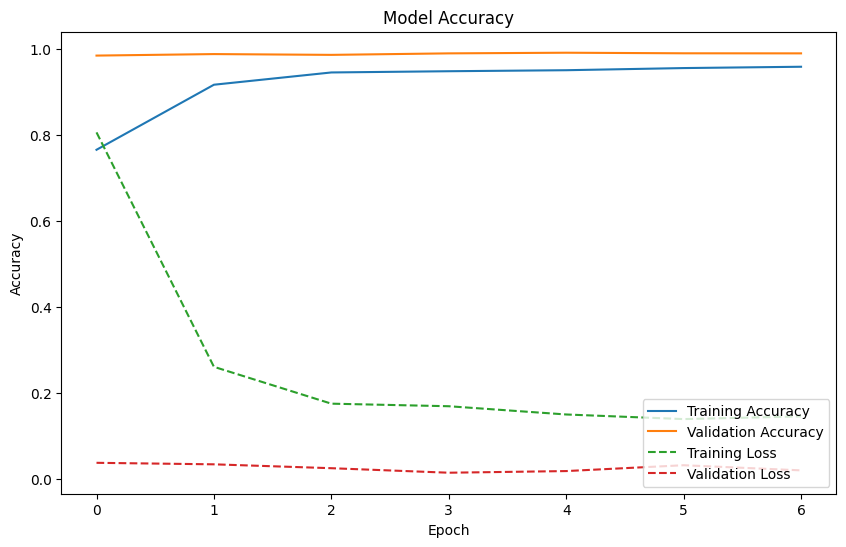

In [5]:
# Import necessary libraries
!pip install patool==1.12
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from google.colab import drive
import patoolib

# Mount Google Drive and extract dataset
drive.mount('/content/drive')
#patoolib.extract_archive("", outdir="/content/extracted_images") # upload dataset to google drive and paste the path here
data_dir = '/content/extracted_images/leapGestRecog'

# batch size
batch_size = 32

# load the dataset without modifications to get class names
train_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=batch_size,
    label_mode='categorical'
)

#return class names before applying transformations
class_names = train_dataset_raw.class_names
num_classes = len(class_names)
print(f"Class Names: {class_names}")
print(f"Number of classes: {num_classes}")

# Data augmentation setup
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

# early stopping setup
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# apply data augmentation for training and load validation dataset
train_dataset = train_dataset_raw.map(lambda x, y: (data_augmentation(x), y))

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=batch_size,
    label_mode='categorical'
)

# load the pre-trained VGG16 model with custom layers and batch normalization
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model layers

# Build the model with batch normalization and custom layers
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)), # input shape layer 224 x 224
    base_model,
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model with Adam optimizer and a learning rate of 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print the model summary
model.summary()

# train the model with early stopping
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(validation_dataset, verbose=2)
print(f"Validation accuracy: {val_acc:.4f}")

# Plot training and validation accuracy and loss
plt.figure(figsize=(10, 6))

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Plot loss
plt.plot(history.history['loss'], label='Training Loss', linestyle='--')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')

# Set title and labels
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Add a legend
plt.legend(loc='lower right')

# Display the chart
plt.show()
